In [100]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

import lightgbm as lgb
# approach provided: https://towardsdatascience.com/survival-analysis-with-lightgbm-plus-poisson-regression-6b3cc897af82

In [122]:
df = pd.read_csv("../input/rental-bike-sharing/hour.csv", parse_dates=["dteday"])
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [123]:
# drop undesired columns
df.drop(["casual", "registered", "instant"], axis=1, inplace=True)

# add hour to dteday
df["dteday"] = df["dteday"] + pd.to_timedelta(df["hr"], unit='h')

In [44]:
def crps(y_true, y_pred):
    y_true = np.clip(np.cumsum(y_true, axis=1), a_min=0, a_max=1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), a_min=0, a_max=1)
    return (np.square(y_true - y_pred)).sum(axis=1).sum(axis=0) / (np.prod(y_true.shape))

In [124]:
# split train/valid/test

x_train = df[df["dteday"] < "2012-01-01"].copy()
x_valid = df[(df["dteday"] >= "2012-01-01")&(df["dteday"] < "2012-05-01")].copy()

x_test = df[df["dteday"] >= "2012-05-01"].copy()

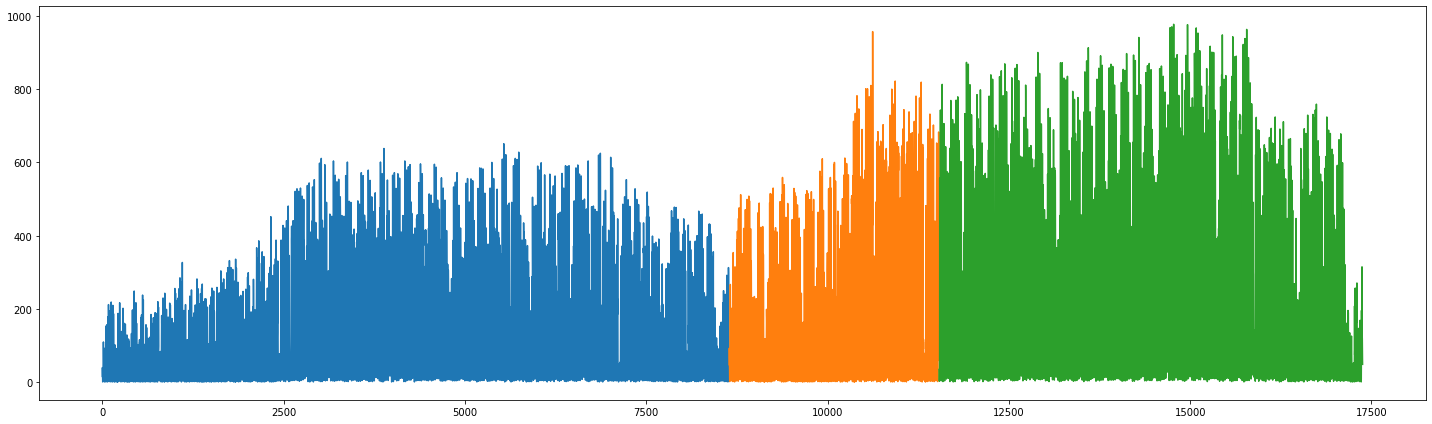

In [37]:
plt.figure(figsize=(20, 6))

plt.plot(np.arange(len(x_train)), x_train["cnt"])
plt.plot(np.arange(len(x_train), len(x_valid)+len(x_train)), x_valid["cnt"])
plt.plot(np.arange(len(x_train) + len(x_valid), len(df)), x_test["cnt"])

plt.tight_layout()
plt.show()
# there is a certain uprising annual trend in rentals

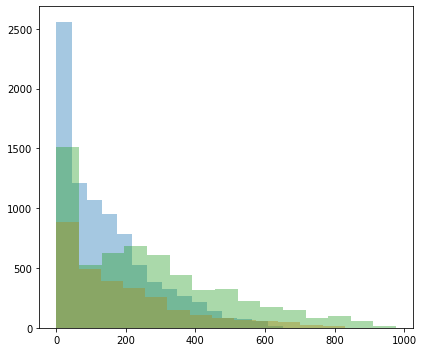

In [39]:
# distribution density of target variable

plt.figure(figsize=(6, 5))

plt.hist(x_train["cnt"], bins=15, alpha=0.4)
plt.hist(x_valid["cnt"], bins=15, alpha=0.4)
plt.hist(x_test["cnt"], bins=15, alpha=0.4)

plt.tight_layout()
plt.show()

In [125]:
max_count = 1000  # df["cnt"].max() = 977

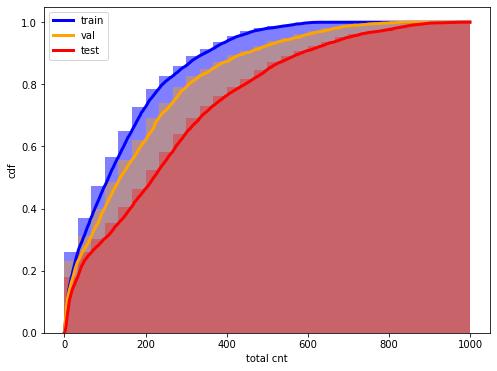

In [61]:
plt.figure(figsize=(8,6))

plt.hist(x_train.cnt, range=(0,max_count), bins=30, cumulative=True, density=True, alpha=0.5, color='blue')
cdf = np.histogram(x_train.cnt, range=(0, max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf, c='blue', linewidth=3, label='train')

plt.hist(x_valid.cnt, range=(0, max_count), bins=30, cumulative=True, density=True, alpha=0.4, color='orange')
cdf = np.histogram(x_valid.cnt, range=(0, max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf, c='orange', linewidth=3, label='val')

plt.hist(x_test.cnt, range=(0, max_count), bins=30, cumulative=True, density=True, alpha=0.3, color='red')
cdf = np.histogram(x_test.cnt, range=(0, max_count), bins=max_count, density=True)[0].cumsum()
plt.plot(cdf, c='red', linewidth=3, label='test')

plt.ylabel('cdf')
plt.xlabel('total cnt')
plt.legend()
plt.show()

In [126]:
columns = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 
           'temp', 'atemp', 'hum', 'windspeed']

In [127]:
x_train['count_so_far'] = x_train.apply(lambda x: np.arange(x.cnt), axis=1)
x_train['stop'] = x_train.apply(lambda x: np.append(np.zeros(x.cnt - 1), 1), axis=1)
x_train = x_train.apply(pd.Series.explode)

x_train['count_so_far'] = x_train["count_so_far"].astype(int)
x_train['stop'] = x_train["stop"].astype(int)

y_train = x_train['stop']
x_train = x_train[columns + ['count_so_far']]

x_train.shape, y_train.shape

((1243103, 13), (1243103,))

In [128]:
x_valid['count_so_far'] = x_valid.apply(lambda x: np.arange(x.cnt), axis=1)
x_valid['stop'] = x_valid.apply(lambda x: np.append(np.zeros(x.cnt - 1), 1), axis=1)
x_valid = x_valid.apply(pd.Series.explode)

x_valid['count_so_far'] = x_valid["count_so_far"].astype(int)
x_valid['stop'] = x_valid["stop"].astype(int)

y_valid = x_valid['stop']
x_valid = x_valid[columns + ['count_so_far']]

x_valid.shape, y_valid.shape

((538980, 13), (538980,))

In [129]:
z_val = df[(df["dteday"] >= "2012-01-01")&(df["dteday"] < "2012-05-01")].copy()

z_val['count_so_far'] = z_val.apply(lambda x: np.arange(max_count), axis=1)
z_val['stop'] = z_val.apply(lambda x: np.append(np.zeros(x.cnt), np.ones(max_count - x.cnt)), axis=1)
z_val = z_val.apply(pd.Series.explode)

z_val['count_so_far'] = z_val["count_so_far"].astype(int)
z_val['stop'] = z_val["stop"].astype(int)

z_tv = z_val['stop']
z_val = z_val[columns + ['count_so_far']]

z_val.shape, z_tv.shape

((2894000, 13), (2894000,))

In [130]:
x_test['count_so_far'] = x_test.apply(lambda x: np.arange(x.cnt), axis=1)
x_test['stop'] = x_test.apply(lambda x: np.append(np.zeros(x.cnt - 1), 1), axis=1)
x_test = x_test.apply(pd.Series.explode)

x_test['count_so_far'] = x_test["count_so_far"].astype(int)
x_test['stop'] = x_test["stop"].astype(int)

y_test = x_test['stop']
x_test = x_test[columns + ['count_so_far']]

x_test.shape, y_test.shape

((1510596, 13), (1510596,))

In [131]:
z = df[df["dteday"] >= "2012-05-01"].copy()

z['count_so_far'] = z.apply(lambda x: np.arange(max_count), axis=1)
z['stop'] = z.apply(lambda x: np.append(np.zeros(x.cnt), np.ones(max_count - x.cnt)), axis=1)
z = z.apply(pd.Series.explode)

z['count_so_far'] = z["count_so_far"].astype(int)
z['stop'] = z["stop"].astype(int)

z_t = z['stop']
z = z[columns + ['count_so_far']]

In [194]:
params = {
         'objective': 'poisson',  # probability of number of events to happen in given time period
         'num_leaves': 30, 
         'learning_rate': 0.001,
         'colsample_bytree': 0.8,
         'subsample': 0.9,
         'bagging_seed': 33,
         'poisson_max_delta_step': 0.8,
         'metric': 'poisson',
         'min_data_in_leaf': 20,
         'max_depth': -1,
         }

In [133]:
train_ds = lgb.Dataset(x_train, y_train)
valid_ds = lgb.Dataset(x_valid, y_valid)

In [195]:
model = lgb.train(params, train_ds, num_boost_round=1000,
                  valid_sets = [train_ds, valid_ds],
                  verbose_eval=50, early_stopping_rounds=150)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 1243103, number of used features: 12
[LightGBM] [Info] Start training from score -4.968385
Training until validation scores don't improve for 150 rounds
[50]	training's poisson: 0.041006	valid_1's poisson: 0.0332051
[100]	training's poisson: 0.0406025	valid_1's poisson: 0.0328712
[150]	training's poisson: 0.0402931	valid_1's poisson: 0.0326266
[200]	training's poisson: 0.0400192	valid_1's poisson: 0.032422
[250]	training's poisson: 0.0397642	valid_1's poisson: 0.0322431
[300]	training's poisson: 0.0395506	valid_1's poisson: 0.0321076
[350]	training's poisson: 0.0393561	valid_1's poisson: 0.0319895
[400]	training's poisson: 0.0391688	valid_1's poisson: 0.0318868
[450]	trai

In [196]:
p_val_hz = model.predict(z_val).reshape(-1, max_count)
p_val = 1 - np.exp(-np.cumsum(p_val_hz, axis=1))
p_val.shape

(2894, 1000)

In [197]:
t_val = z_tv.values.reshape(-1, max_count)
t_val.shape

(2894, 1000)

In [198]:
crps(t_val, p_val)

0.1750881451896175

In [199]:
p_test_hz = model.predict(z).reshape(-1, max_count)
p_test = 1 - np.exp(-np.cumsum(p_test_hz, axis=1))
p_test.shape

(5840, 1000)

In [200]:
t_test = z_t.values.reshape(-1, max_count)
t_test.shape

(5840, 1000)

In [201]:
crps(t_test, p_test)

0.2461765808215057

In [202]:
# baseline

crps(t_test, np.repeat(cdf, len(t_test)).reshape(-1,max_count))

0.2586829928114133

In [256]:
from tqdm import trange 

p_test[p_test >= .85] = 1  # with threshold
counts = np.zeros((p_test.shape[0]))
for i in trange(p_test.shape[0]):
    try:
        counts[i] = np.argwhere(p_test[i] == 1)[0][0]
    except:
        counts[i] = p_test.shape[1]
    
r2_score(df.loc[df["dteday"] >= "2012-05-01", "cnt"].values, counts)

100%|██████████| 5840/5840 [00:00<00:00, 79442.99it/s]


0.5102848606041911

In [148]:
r2_score(df.loc[df["dteday"] >= "2012-05-01", "cnt"].values, t_test.argmax(axis=1))

1.0

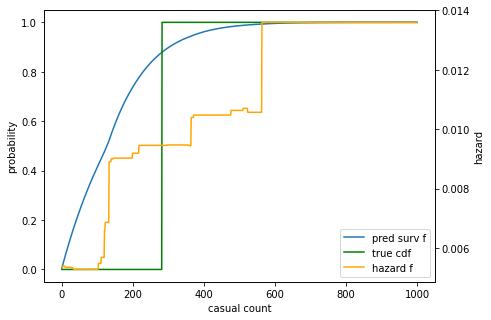

In [255]:
_id = 21

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.ylabel('probability')
plt.xlabel('casual count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')
plt.show()